<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clean" data-toc-modified-id="Clean-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clean</a></span></li><li><span><a href="#Raw" data-toc-modified-id="Raw-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Raw</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiments</a></span><ul class="toc-item"><li><span><a href="#Create-db-from-df" data-toc-modified-id="Create-db-from-df-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create db from df</a></span></li></ul></li></ul></div>

# Clean

epoch,train_loss,valid_loss,time
0,0.057461,0.043099,00:26


epoch,train_loss,valid_loss,time
0,0.006214,0.015893,00:33
1,0.003199,0.006799,00:33
2,0.001574,0.009723,00:34


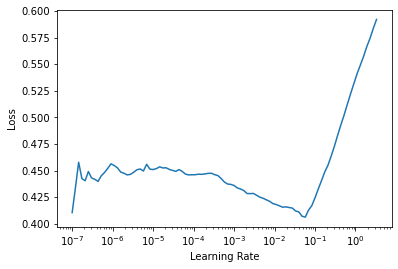

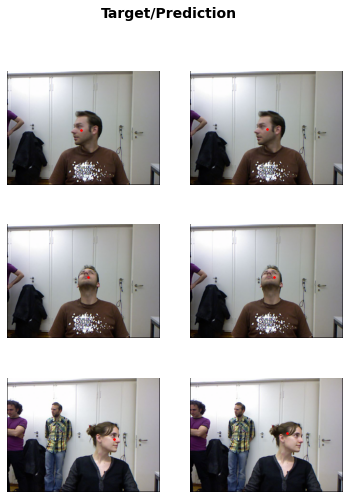

In [ ]:
from fastai.vision.all import *

### grab data
path = untar_data(URLs.BIWI_HEAD_POSE)
ims = get_image_files(path).sorted()                    # only used for inspecting data; not used in rest of nb

### get_y
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')  # im_fn → pose_fn by doing 'rgb.jpg' → 'pose.txt'
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) # use 01's cal file to calibrate all ims below
def get_ctr(fn):                                        # im file → point tensor
    ctr = np.genfromtxt(img2pose(fn), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

### data loaders via datablock
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda itm: itm.parent.name=='02' or itm.parent.name=='14'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)
dls = db.dataloaders(path)

### train
learner = cnn_learner(dls, resnet18, y_range=(-1,1))
lr_min,lr_steep = learner.lr_find()
learner.fine_tune(3,lr_min) 
learner.show_results(ds_idx=1, figsize=(6,8))           # accuracy = sqrt(valid_loss)

# Raw

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path
print(*path.ls().sorted(),sep='\n')

/home/rory/.fastai/data/biwi_head_pose/01
/home/rory/.fastai/data/biwi_head_pose/01.obj
/home/rory/.fastai/data/biwi_head_pose/02
/home/rory/.fastai/data/biwi_head_pose/02.obj
/home/rory/.fastai/data/biwi_head_pose/03
/home/rory/.fastai/data/biwi_head_pose/03.obj
/home/rory/.fastai/data/biwi_head_pose/04
/home/rory/.fastai/data/biwi_head_pose/04.obj
/home/rory/.fastai/data/biwi_head_pose/05
/home/rory/.fastai/data/biwi_head_pose/05.obj
/home/rory/.fastai/data/biwi_head_pose/06
/home/rory/.fastai/data/biwi_head_pose/06.obj
/home/rory/.fastai/data/biwi_head_pose/07
/home/rory/.fastai/data/biwi_head_pose/07.obj
/home/rory/.fastai/data/biwi_head_pose/08
/home/rory/.fastai/data/biwi_head_pose/08.obj
/home/rory/.fastai/data/biwi_head_pose/09
/home/rory/.fastai/data/biwi_head_pose/09.obj
/home/rory/.fastai/data/biwi_head_pose/10
/home/rory/.fastai/data/biwi_head_pose/10.obj
/home/rory/.fastai/data/biwi_head_pose/11
/home/rory/.fastai/data/biwi_head_pose/11.obj
/home/rory/.fastai/data/biwi_hea

In [ ]:
print(*((path/'14').ls().sorted())[0:10], sep='\n')

/home/rory/.fastai/data/biwi_head_pose/14/depth.cal
/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_pose.txt
/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_rgb.jpg
/home/rory/.fastai/data/biwi_head_pose/14/frame_00004_pose.txt
/home/rory/.fastai/data/biwi_head_pose/14/frame_00004_rgb.jpg
/home/rory/.fastai/data/biwi_head_pose/14/frame_00005_pose.txt
/home/rory/.fastai/data/biwi_head_pose/14/frame_00005_rgb.jpg
/home/rory/.fastai/data/biwi_head_pose/14/frame_00006_pose.txt
/home/rory/.fastai/data/biwi_head_pose/14/frame_00006_rgb.jpg
/home/rory/.fastai/data/biwi_head_pose/14/frame_00007_pose.txt


In [ ]:
path.parent,path.name

(Path('/home/rory/.fastai/data'), 'biwi_head_pose')

##### I made an ims_iter so I can rapidly ctrl+enter through next(ims_iter) like a flip book.

In [ ]:
ims = get_image_files(path).sorted()
ims_iter = iter(ims)
len(ims)

15678

/home/rory/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg


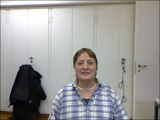

In [ ]:
next_im = next(ims_iter)
print(next_im)
im = PILImage.create(next_im).to_thumb(160)
im

##### These are the labels. They appear to contain three x,y,z keypoints, and one other x,y,z.

In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_pose.txt'

0.999884 0.00399683 -0.0147057 
-0.00332519 0.998963 0.0454161 
0.0148719 -0.045362 0.99886 

56.6861 14.9852 879.29 



##### Calibration files for depth and rgb.

In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/depth.cal'

575.816 0 320 
0 575.816 240 
0 0 1 

0 0 0 0 

1 0 0 
0 1 0 
0 0 1 

0 0 0 

640 480


In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/rgb.cal'

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480


##### Given an im path, produce the text file containing its label

In [ ]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt') # 'rgb.jpg' → 'pose.txt'

##### Given an im path, produce its label tensor

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) # calibrate all sequences to 01

def get_ctr(fn):
    ctr = np.genfromtxt(img2pose(fn), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
f_ex = '/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_rgb.jpg'

In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_pose.txt'

0.999884 0.00399683 -0.0147057 
-0.00332519 0.998963 0.0454161 
0.0148719 -0.045362 0.99886 

56.6861 14.9852 879.29 



In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/01/rgb.cal'

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480


In [ ]:
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [ ]:
get_ctr(Path(f_ex))

tensor([353.3737, 249.3225])

Looking inside get_ctr...

In [ ]:
ctr = np.genfromtxt(img2pose(f_ex), skip_header=3); ctr

array([ 56.6861,  14.9852, 879.29  ])

In [ ]:
c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]; c1

353.37374877674034

In [ ]:
ctr[0]

56.6861

In [ ]:
c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]; c2

249.32248558587042

##### data block

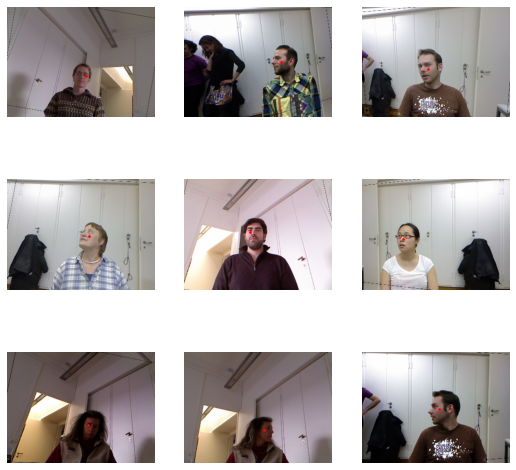

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda itm: itm.parent.name=='02'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

dls = db.dataloaders(path)
dls.show_batch(max_n=9)

In [ ]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

##### Train

In [ ]:
learner = cnn_learner(dls, resnet18, y_range=(-1,1), loss_func=MSELossFlat())

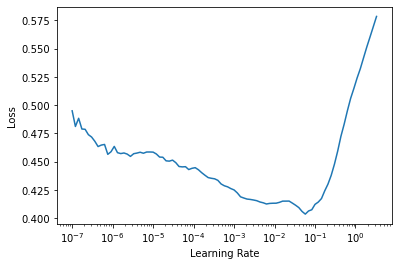

In [ ]:
lr_min,lr_steep = learner.lr_find()

In [ ]:
lr = (lr_min+lr_steep)/2

*`fine_tune(3,lr)` will train the new output layer one epoch and then everything together 3 epochs.*

In [ ]:
learner.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.086677,0.052032,00:26


epoch,train_loss,valid_loss,time
0,0.005435,0.018010,00:34
1,0.002755,0.022240,00:34
2,0.001734,0.022840,00:34


In [ ]:
# Take sqrt of MSE loss to find accuracy
math.sqrt(0.000483), math.sqrt(0.000282), math.sqrt(0.000038)

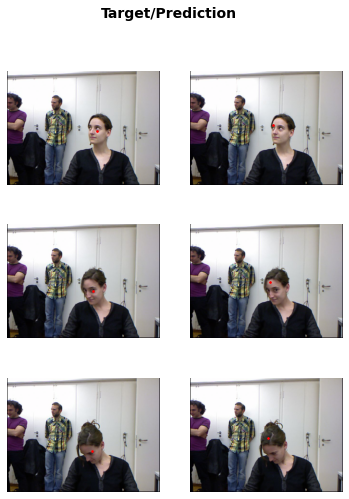

In [ ]:
learner.show_results(ds_idx=1, figsize=(6,8))

In [ ]:
# interesting – this model is worse at predicting results for this grill.

# Experiments

## Create db from df

In [ ]:
from fastai.vision.all import *

### grab data
path = untar_data(URLs.BIWI_HEAD_POSE)
ims = get_image_files(path).sorted()                    # only used for inspecting data; not used in rest of nb

### get_y
def img2pose(fn): return Path(f'{str(fn)[:-7]}pose.txt')  # im_fn → pose_fn by doing 'rgb.jpg' → 'pose.txt'
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) # use 01's cal file to calibrate all ims below
def get_ctr(fn):                                        # im file → point tensor
    ctr = np.genfromtxt(img2pose(fn), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

### data loaders via datablock
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda itm: itm.parent.name=='02' or itm.parent.name=='14'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)
dls = db.dataloaders(path)

In [ ]:
xb,yb = dls.one_batch()
xb.shape

torch.Size([64, 3, 240, 320])

In [ ]:
### train
learner = cnn_learner(dls, resnet18, y_range=(-1,1))
lr_min,lr_steep = learner.lr_find()
learner.fine_tune(3,lr_min) 
learner.show_results(ds_idx=1, figsize=(6,8))           # accuracy = sqrt(valid_loss)

In [ ]:
df = pd.DataFrame({'a': 'a b c d'.split(), 'b': ['1 2', '0', '', '1 2 3']})
f = ColReader('a', pref='0', suff='1')
test_eq([f(o) for o in df.itertuples()], '0a1 0b1 0c1 0d1'.split())

In [ ]:
df

,a,b
0,a,1 2
1,b,0
2,c,
3,d,1 2 3


In [ ]:
[f(o) for o in df.itertuples()]

['0a1', '0b1', '0c1', '0d1']